# Tutorial: Building Your Own Chatbot and Rap Bot with vLLM 
`Date`: 2025/1/17 | `Author`: Mahdi Ghodsi | `Tag`: vLLM, Chatbot, Llama, ROCm | `Category`: AI, Inference

In this tutorial, we’ll walk through:

1. [Environment Setup with Docker and ROCm](#env-setup)  
2. [Launching Jupyter Notebooks in a Docker Container](#launch-jupyter)  
3. [Installing and Configuring Hugging Face and vLLM](#hugging-face-token)  
4. [Building a Basic Chatbot with vLLM](#basic-chatbot)  
5. [Transforming It into a Rap Bot](#rap-bot)  
6. [Enhancing Responses with Few-Shot Prompting](#few-shot)

We’ll be using **vLLM** for large language model inference. vLLM optimizes text generation workloads by effectively batching requests and utilizing GPU resources, offering **high throughput** and **low latency**—perfect for chatbots.

---

<a id="env-setup"></a>
## 1. Environment Setup with Docker and ROCm

## **Prerequisites**

### 1. **AMD Instinct™ GPUs**  
   E.g., MI300X. Make sure your system meets the [System Requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### 2. **ROCm 6.2 or higher installed** and verified on your system.  
   Refer to the official [ROCm setup instructions](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html#).

   Verify with:
   ```bash
   rocm-smi
   ```
   You should see your GPU(s) listed.

### 3. **Docker installed**  
   Check the [Docker installation guide](https://docs.docker.com/get-docker/). Ensure you have Docker permission configured:
   ```bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

### 4. **Hugging Face API** (Required)  
   Obtain an API token from [Hugging Face](https://huggingface.co) and ensure you have access permissions for [Meta's LLaMA checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B).

---

### **Launch the Docker Container**

From your host machine, run:

```bash
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  --hostname=ROCm-FT \
  --env HUGGINGFACE_HUB_CACHE=/workspace \
  -v /path/to/notebooks:/workspace/notebooks \
  -w /workspace/notebooks \
  --entrypoint /bin/bash \
  rocm/vllm:rocm6.2_mi300_ubuntu20.04_py3.9_vllm_0.6.4
```

**Important**:  
- Replace `/path/to/notebooks` with the absolute path on your host for storing notebooks.  
- Inside the container, your working directory will be `/workspace/notebooks`.

---

<a id="launch-jupyter"></a>
## 2. Launch Jupyter Notebooks in the Container

**Inside the Docker container**, install and launch Jupyter (if not already):

```bash
pip install jupyter
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

You’ll see an output with a URL and token. Copy/paste that into your browser on your host to open JupyterLab.

---

<a id="hugging-face-token"></a>
## 3. Provide Your Hugging Face Token

You will need a Hugging Face API token to access Llama-3.1-8B. Tokens typically start with "hf_". Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.1-8B](https://huggingface.co/meta-llama/Llama-3.1-8B).

Run the following interactive block in your Jupyter notebook to set up the token:

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()


Verify that your token was captured correctly:

In [ ]:
# Validate the token
try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")



---

<a id="basic-chatbot"></a>
## 4. Building a Basic Chatbot with vLLM

Let's define a Chatbot classs.  

In [ ]:
from vllm import LLM, SamplingParams
import gc
import torch
import time

class Chatbot:
    def __init__(self):
        self.history = []
        self.system_instruction = (
            "You are a helpful and professional chatbot. "
            "Keep your responses concise, friendly, and relevant."
        )
        self.llm = self.load_model()

    def load_model(self):
        model_name = "meta-llama/Meta-Llama-3-8B-Instruct"  # Adjust if using another model
        print("Loading the model. Please wait...")
        llm = LLM(model=model_name)
        print("Model loaded successfully!")
        return llm

    def construct_prompt(self, user_input):
        recent_history = self.history[-4:]
        conversation = [{"role": "system", "content": self.system_instruction}] +                        recent_history +                        [{"role": "user", "content": user_input}]
        return conversation

    def generate_response(self, conversation, max_tokens=200):
        sampling_params = SamplingParams(
            temperature=0.7,
            top_p=0.9,
            max_tokens=max_tokens
        )
        outputs = self.llm.chat(conversation, sampling_params)
        reply = outputs[0].outputs[0].text
        return reply

    def get_response(self, user_input):
        conversation = self.construct_prompt(user_input)
        bot_response = self.generate_response(conversation)
        self.history.append({"role": "user", "content": user_input})
        self.history.append({"role": "bot", "content": bot_response})
        return bot_response
    
    def cleanup(self):
        """
        Clean up resources and release GPU memory.
        """
        if hasattr(self, "llm") and self.llm:
            print("Cleaning up GPU memory...")
            del self.llm  # Delete the LLM object
            gc.collect()
            torch.cuda.empty_cache()  # Clear CUDA cache
            time.sleep(5)  # Add a 2-second wait before the final message
            print("Cleanup complete!")



**Test**
--- 
Now test it (Please note that this will produce a text box to interact with the chatbot):

In [ ]:
chatbot = Chatbot()
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting chatbot...")
        break
    response = chatbot.get_response(user_input)
    print(f"Bot: {response}")

chatbot.cleanup()

***IMPORTANT***: Please exit the chat above by typying `exit` or `quit` before proceeding to the next section. 

---

<a id="rap-bot"></a>
## 5. Transforming It into a Rap Bot

Let’s create a subclass or variation of our chatbot that instructs the model to respond in **rap style**:

In [ ]:
class RapChatbot(Chatbot):
    def __init__(self):
        super().__init__()
        self.system_instruction = (
            "You are a skilled rapper chatbot. "
            "All your responses should rhyme, flow, and contain rap-like lyrics. "
            "Keep it concise yet rhythmic."
        )

**Test**
--- 
Now test it (Please note that this will produce a text box to interact with the chatbot):

In [ ]:
rapbot = RapChatbot()
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting chatbot...")
        break
    response = rapbot.get_response(user_input)
    print(f"Bot: {response}")

rapbot.cleanup()


***IMPORTANT***: Please exit the chat above by typying `exit` or `quit` before proceeding to the next section. 

---

## 6. Enhancing Responses with Few-Shot Prompting

Our RapBot is almost ready. In this section, we leverage **few-shot prompting** to significantly improve the bot's quality by providing examples of expected behavior. If you noticed, the answers were longer and they all started with 'Yo'. Through the examples we are giving, we can enhance the quality. Modify the chatbot initialization to include these examples:

In [ ]:
class EnhancedRapChatbot(RapChatbot):
    def __init__(self):
        super().__init__()
        self.system_instruction = (
            "You are a talented rapper. Every response you give should be in a short rap style, "
            "with rhymes, rhythm, and flow. Keep it engaging and fun but concise! DO NOT START your conversation with 'Yo, listen up.'"
        )
        self.few_shot_examples = [
            {"role": "user", "content": "Hi?"},
            {"role": "bot", "content": "Hey, what's good, my friend? Let's chat it up, the rhymes won't end!"},
            {"role": "user", "content": "Tell me about the weather today."},
            {"role": "bot", "content": "The sun's out bright, no clouds in sight, it's a perfect day to feel all right!"},
            {"role": "user", "content": "What's the capital of France?"},
            {"role": "bot", "content": "Paris is the name, yeah, that's the place, where the Eiffel Tower lights up the space!"},
        ]

    def construct_prompt(self, user_input):
        conversation = [
            {"role": "system", "content": self.system_instruction}
        ] + self.few_shot_examples + self.history[-4:] + [
            {"role": "user", "content": user_input}
        ]
        return conversation

**Test**
--- 
Test the enhanced rapbot (Please note that this will produce a text box to interact with the chatbot):

In [ ]:
enhanced_rapbot = EnhancedRapChatbot()
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        print("Exiting chatbot...")
        break
    response = enhanced_rapbot.get_response(user_input)
    print(f"Bot: {response}")

enhanced_rapbot.cleanup()

***IMPORTANT***: Please exit the chat above by typying `exit` or `quit` before proceeding to the next section. 

---
<a id="gradio-gui"></a>
## 7. Optional: Launching a GUI with Gradio

If you'd like to provide a graphical interface for your chatbot, you can use **Gradio** to create an interactive web-based UI.

### **Install Gradio**

Inside your container or Python environment:



In [ ]:
!pip install gradio


### **Create the Gradio Interface**

Add this to your notebook or script:



In [ ]:
import gradio as gr
enhanced_rapbot = EnhancedRapChatbot()

# Define the function to interact with Gradio
def chat(user_input, max_tokens, temperature, top_p):
    response = enhanced_rapbot.get_response(user_input)
    return response

# Create the Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Enhanced RapBot")
    with gr.Row():
        with gr.Column(scale=0.7):
            chatbot_ui = gr.Chatbot()
            user_input = gr.Textbox(placeholder="Type your message here...")
            submit_button = gr.Button("Send")
        with gr.Column(scale=0.3):
            max_tokens = gr.Slider(50, 500, value=200, step=10, label="Max Tokens")
            temperature = gr.Slider(0.0, 1.0, value=0.7, step=0.1, label="Temperature")
            top_p = gr.Slider(0.0, 1.0, value=0.9, step=0.1, label="Top-p")

    def respond(message, chat_history, max_tokens, temperature, top_p):
        bot_response = chat(message, max_tokens, temperature, top_p)
        chat_history.append((message, bot_response))
        return chat_history, ""

    submit_button.click(respond, [user_input, chatbot_ui, max_tokens, temperature, top_p], [chatbot_ui, user_input])

# Launch the Gradio app
demo.launch(share=True)




### **Run the Gradio App**

Execute the code block above to launch the GUI. The interface will display in your browser, allowing you to interact with the chatbot using sliders to adjust parameters like `max_tokens`, `temperature`, and `top-p`.

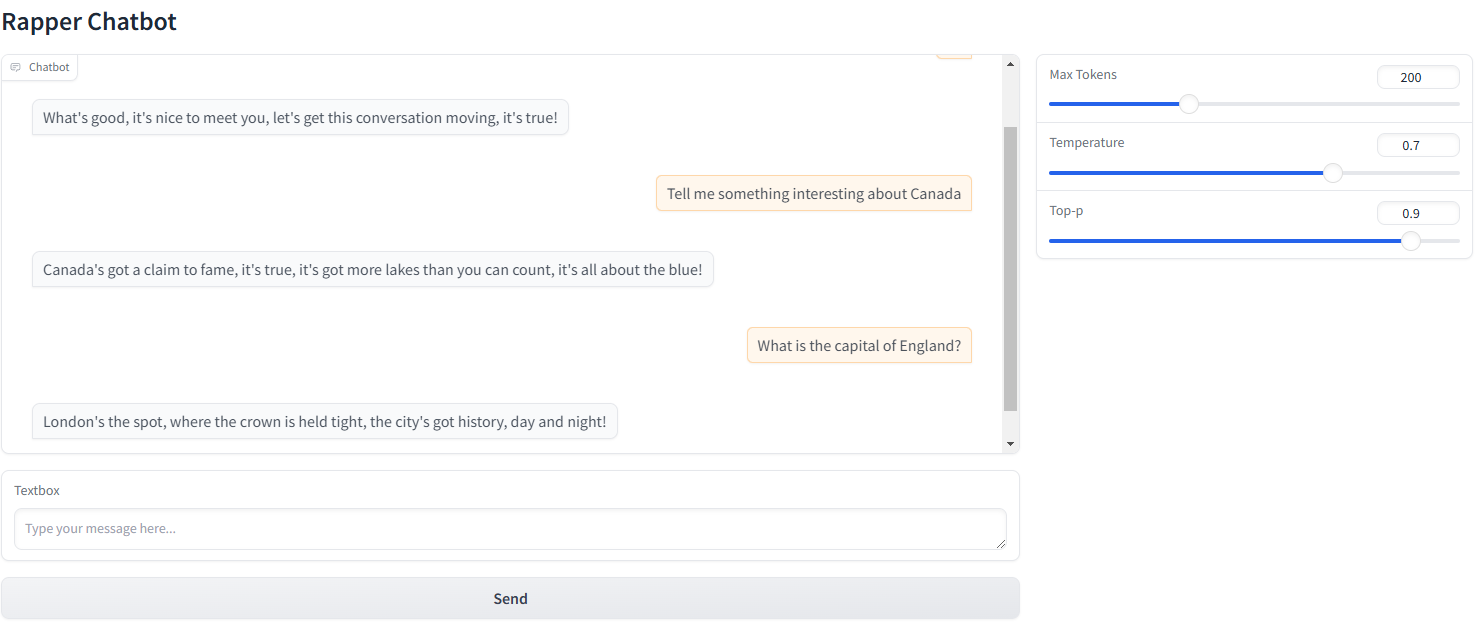


## **Conclusion and Next Steps**

- We configured a Docker environment with ROCm 6.2+ and vLLM.
- Built a chatbot class with vLLM.
- Extended it into a rap-style chatbot.

Enjoy experimenting with your chatbot and rap bot! For further learning, visit the [vLLM GitHub page](https://github.com/vllm-project/vllm).
